In [1]:
! git clone https://github.com/SwapnilDreams100/calling-out-bluff.git

Cloning into 'calling-out-bluff'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 3471 (delta 3), reused 12 (delta 2), pack-reused 3455
Receiving objects: 100% (3471/3471), 908.76 MiB | 20.18 MiB/s, done.
Resolving deltas: 100% (711/711), done.
Checking out files: 100% (3481/3481), done.


In [2]:
! pip install alibi xhtml2pdf 

     |████████████████████████████████| 235kB 4.2MB/s 
     |████████████████████████████████| 102kB 4.9MB/s 
     |████████████████████████████████| 327kB 7.0MB/s 
     |████████████████████████████████| 81kB 6.3MB/s 
     |████████████████████████████████| 2.6MB 8.8MB/s 
     |████████████████████████████████| 28.0MB 162kB/s 
  Created wheel for xhtml2pdf: filename=xhtml2pdf-0.2.5-cp36-none-any.whl size=234491 sha256=b79444735046e34ef59e44bd92ce1ebf780693252a7d7edb78b3ae9999112c39
  Stored in directory: /root/.cache/pip/wheels/69/0f/15/6f8008b18ca84c08c198445b465c8038f745e444d7251a8266
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463901 sha256=f383301d526dee5d45f22b0b3b5fab79b372621220d280a2c453e5ab6562564c
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
  Created wheel for pyPdf2: filename=PyPDF2-1.26.0-cp36-none-any.whl size=61087 sha256=6e883a00cc81ef1ba26cfcf8f4e1b1348dad7845fa75f73ab39e

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! cp ./drive/My\ Drive/glove.6B.300d.txt ./

In [5]:
essay_type = '7'

import keras.layers as klayers 
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Input, Embedding, GlobalAveragePooling1D, Concatenate, Activation, Lambda, BatchNormalization, Convolution1D, Dropout
from keras.preprocessing.text import Tokenizer
import numpy as np
import nltk
nltk.download('punkt')
# from quadratic_weighted_kappa import QWK
from sklearn.metrics import cohen_kappa_score
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import initializers
from scipy import stats
import matplotlib as mpl
from IPython.display import HTML
from alibi.explainers import IntegratedGradients
import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
import gc
import matplotlib.pyplot as plt
from collections import Counter
# tf.disable_v2_behavior()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
class Neural_Tensor_layer(Layer):
	def __init__(self,output_dim,input_dim=None, **kwargs):
		self.output_dim=output_dim
		self.input_dim=input_dim
		if self.input_dim:
			kwargs['input_shape']=(self.input_dim,)
# 		print("YAYY", input_dim, output_dim)
		super(Neural_Tensor_layer,self).__init__(**kwargs)

	def call(self,inputs,mask=None):
		e1=inputs[0]
		e2=inputs[1]
		batch_size=K.shape(e1)[0]
		k=self.output_dim
		
		feed_forward=K.dot(K.concatenate([e1,e2]),self.V)

		bilinear_tensor_products = [ K.sum((e2 * K.dot(e1, self.W[0])) + self.b, axis=1) ]

		for i in range(k)[1:]:	
			btp=K.sum((e2*K.dot(e1,self.W[i]))+self.b,axis=1)
			bilinear_tensor_products.append(btp)

		result=K.tanh(K.reshape(K.concatenate(bilinear_tensor_products,axis=0),(batch_size,k))+feed_forward)

		return result
    
	def build(self,input_shape):
		mean=0.0
		std=1.0
		k=self.output_dim
		d=self.input_dim
		##truncnorm generate continuous random numbers in given range
		W_val=stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(k,d,d))
		V_val=stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(2*d,k))
		self.W=K.variable(W_val)
		self.V=K.variable(V_val)
		self.b=K.zeros((self.input_dim,))
		self.trainable_weights.append([self.W,self.V,self.b])

	def compute_output_shape(self, input_shape):
		batch_size=input_shape[0][0]
		return(batch_size,self.output_dim)
  

class Temporal_Mean_Pooling(Layer): # conversion from (samples,timesteps,features) to (samples,features)
	def __init__(self, **kwargs):
		super(Temporal_Mean_Pooling,self).__init__(**kwargs)
		# masked values in x (number_of_samples,time)
		self.supports_masking=True
		# Specifies number of dimensions to each layer
		self.input_spec=InputSpec(ndim=3)
        
	def call(self,x,mask=None):
		if mask is None:
			mask=K.mean(K.ones_like(x),axis=-1)

		mask=K.cast(mask,K.floatx())
				#dimension size single vec/number of samples
		return K.sum(x,axis=-2)/K.sum(mask,axis=-1,keepdims=True)        

	def compute_mask(self,input,mask):
		return None
    
	def compute_output_shape(self,input_shape):
		return (input_shape[0],input_shape[2])

In [7]:
main_path = './calling-out-bluff/Model3(SkipFlow)/'

In [8]:
EMBEDDING_DIM=300
MAX_NB_WORDS=4000

MAX_SEQUENCE_LENGTH=500
VALIDATION_SPLIT=0.20
DELTA=20

texts=[]
labels=[]

originals = []

fp1=open("glove.6B.300d.txt","r", encoding="utf-8")
glove_emb={}
for line in fp1:
  temp=line.split(" ")
  try:
    glove_emb[temp[0]]=np.asarray([float(i) for i in temp[1:]])
  except Exception as e:
    pass

In [9]:
fp=open(main_path+"data/training_set_rel3.tsv",'r', encoding="ascii", errors="ignore")
fp.readline()
originals = []
for line in fp:
    temp=line.split("\t")
    if(temp[1]==essay_type): ## why only 4 ?? - evals in prompt specific fashion
        originals.append(float(temp[6]))
# print(originals)
fp.close()
# print(originals)
print("range min - ", min(originals) , " ; range max - ", max(originals))

range_min = min(originals)
range_max = max(originals)

fp=open(main_path+"data/training_set_rel3.tsv",'r', encoding="ascii", errors="ignore")
fp.readline()
sentences=[]
for line in fp:
    temp=line.split("\t")
    if(temp[1]==essay_type): ## why only 4 ?? - evals in prompt specific fashion
        texts.append(temp[2])
        labels.append((float(temp[6])-range_min)/(range_max-range_min)) ## why ??  - normalize to range [0-1]
        line=temp[2].strip()
        sentences.append(nltk.tokenize.word_tokenize(line))

fp.close()
orig_labels  = labels

range min -  2.0  ; range max -  24.0


In [10]:
for i in sentences:
	temp1=np.zeros((1, EMBEDDING_DIM))
	for w in i:
		if(w in glove_emb):
			temp1+=glove_emb[w]
	temp1/=len(i)

In [11]:
tokenizer=Tokenizer(nb_words = MAX_NB_WORDS) #num_words=MAX_NB_WORDS) #limits vocabulory size
tokenizer.fit_on_texts(texts) #encoding the text
sequences=tokenizer.texts_to_sequences(texts) #returns list of sequences
word_index=tokenizer.word_index #dictionary mapping, word and specific token for that word...
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) #padding to max_length

The `nb_words` argument in `Tokenizer` has been renamed `num_words`.


Found 10432 unique tokens.


In [12]:
np.random.seed(0)
indices=np.arange(data.shape[0]) #with one argument, start=0, step =1
print(data.shape)
np.random.shuffle(indices)
data=data[indices]
print(data.shape)
labels=np.asarray(labels)
labels=labels[indices]
# np.reshape(labels, ())
print(labels.shape)
validation_size=int(VALIDATION_SPLIT*data.shape[0])
print(validation_size)

(1569, 500)
(1569, 500)
(1569,)
313


In [13]:
x_train=data[:-validation_size] #data-validation data
print(x_train.shape)
# print(x_train)
# print(labels)
y_train=labels[:-validation_size]
# print(y_train.transpose)
print(y_train.shape)
# y_train = np.reshape(y_train, (1427, 1))
# print(y_train_new)
# print(y_train)
x_val=data[-validation_size:]
print(x_val.shape)
y_val=labels[-validation_size:]

(1256, 500)
(1256,)
(313, 500)


In [14]:
embedding_matrix = np.zeros((len(word_index), EMBEDDING_DIM))
for word,i in word_index.items():
	if(i>=len(word_index)):
		continue
	if word in glove_emb:
			embedding_matrix[i]=glove_emb[word]
vocab_size=len(word_index)
print(vocab_size)

10432


In [15]:
embedding_layer=Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],
							input_length=MAX_SEQUENCE_LENGTH,
							mask_zero=True,
							trainable=False)
# print(embedding_layer.shape)
side_embedding_layer=Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],
							input_length=MAX_SEQUENCE_LENGTH,
							mask_zero=False,
							trainable=False)

In [16]:
def SKIPFLOW(lstm_dim=50, lr=1e-4, lr_decay=1e-6, k=4, eta=3, delta=50, activation="relu", maxlen=MAX_SEQUENCE_LENGTH, seed=None):
    e = Input(name='essay',shape=(maxlen,))
    print("e", e)
#     trad_feats=Input(shape=(7,))
#     print("trad_feats", trad_feats)
    embed = embedding_layer(e)
    print(embed.shape)
    lstm_layer=LSTM(lstm_dim,return_sequences=True)
    # print(lstm_layer)
    hidden_states=lstm_layer(embed)
    htm=Temporal_Mean_Pooling()(hidden_states)    
    side_embed = side_embedding_layer(e)
    side_hidden_states=lstm_layer(side_embed)    
    tensor_layer=Neural_Tensor_layer(output_dim=k,input_dim=500)
#     print(input_dim, output_dim)
    pairs = [((eta + i * delta) % maxlen, (eta + i * delta + delta) % maxlen) for i in range(maxlen // delta)]
    hidden_pairs = [ (Lambda(lambda t: t[:, p[0], :])(side_hidden_states), Lambda(lambda t: t[:, p[1], :])(side_hidden_states)) for p in pairs]
    sigmoid = Dense(1, activation="sigmoid", kernel_initializer=initializers.glorot_normal(seed=seed))
    coherence = [sigmoid(tensor_layer([hp[0], hp[1]])) for hp in hidden_pairs]
    co_tm=Concatenate()(coherence[:]+[htm])
    dense = Dense(256, activation=activation,kernel_initializer=initializers.glorot_normal(seed=seed))(co_tm)
    dense = Dense(128, activation=activation,kernel_initializer=initializers.glorot_normal(seed=seed))(dense)
    dense = Dense(64, activation=activation,kernel_initializer=initializers.glorot_normal(seed=seed))(dense)
    out = Dense(1, activation="sigmoid")(dense)
    model = Model(inputs=[e], outputs=[out])
    print("input", [e])
    print("outputs", out)
    adam = Adam(lr=lr, decay=lr_decay)
    model.compile(loss="mean_squared_error", optimizer=adam, metrics=["MSE"])
    return model

In [17]:
earlystopping = EarlyStopping(monitor="val_mean_squared_error", patience=5)
sf = SKIPFLOW(lstm_dim=500, lr=2e-4, lr_decay=2e-6, k=4, eta=13, delta=50, activation="relu", seed=None)
# sf.summary()

e KerasTensor(type_spec=TensorSpec(shape=(None, 500), dtype=tf.float32, name='essay'), name='essay', description="created by layer 'essay'")
(None, 500, 300)
input [<KerasTensor: shape=(None, 500) dtype=float32 (created by layer 'essay')>]
outputs KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")


In [18]:
# sf.load_weights(main_path+'weights_final/'+essay_type+'_weights.h5')

In [19]:
import pickle
pklfile= "./drive/My Drive/sf_models/"+essay_type+"_weights.pkl"
fpkl= open(pklfile, 'rb')   
sf.set_weights(pickle.load(fpkl))
fpkl.close()

In [20]:
import pandas as pd
import nltk
from nltk import tokenize
import pickle
from random import shuffle
import random
import numpy as np
from scipy import spatial
from xhtml2pdf import pisa
import math
from alibi.explainers import IntegratedGradients as alibi_ig
import matplotlib as mpl
from collections import Counter
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import os
import copy
import gc

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1CIEpiDmzLmJ6LMCVSOmCKw_eOg4ocuS4', dest_path='/content/AES.zip', unzip=True)

preds_main = sf.predict(x_val)
preds_main =[int(round(a*(range_max-range_min)+range_min)) for a in preds_main.flatten().tolist()]

Unzipping...Done.


In [21]:
class gen_adv_examples:
    def __init__(self, maxlen, tokenizer, prompt, model, input_name, type_ig, model_name, val_preds):
        self.MAX_SEQUENCE_LENGTH = maxlen
        self.tokenizer = tokenizer
        self.word_map = tokenizer.word_index
        self.reversed_word_map = dict(map(reversed, self.word_map.items()))
        self.prompt = prompt
        self.model = model
        self.input_name = input_name
        self.type_ig = type_ig
        prompt_to_range = {'1':[2,12],'2':[1,6],'3':[0,3],'4':[0,3],'5':[0,4],'6':[0,4],'7':[0,30],'8':[0,60]}
        self.range_min = prompt_to_range[self.prompt][0]
        self.range_max = prompt_to_range[self.prompt][1]
        self.model_name = model_name
        self.ATTRS_DIR = '/content/drive/My Drive/IG RESULTS/'+self.model_name+'/P'+self.prompt+'/'
        self.ATTRS_TSV = self.ATTRS_DIR + 'attrs.tsv'
        self.small_preds_orig = []
        self.big_preds_orig   = val_preds

    def normalize(self, labels):
        if type(labels) == 'numpy.ndarray':
          labels_new = labels.flatten().tolist()
        else:
          labels_new = copy.deepcopy(labels)
        l = [0]*len(labels_new)
        for i, label in enumerate(labels_new):
          l[i] = (float(label)-self.range_min)/(self.range_max-self.range_min)
        return l
    
    def denormalize(self, labels):
        if type(labels) == 'numpy.ndarray':
          labels_new = labels.flatten().tolist()
        else:
          labels_new = copy.deepcopy(labels)
        l = [0]*len(labels_new)
        for i, label in enumerate(labels_new):
          if math.isnan(labels_new[i]):
            l[i] = self.range_min
          else:
            l[i] = int(label*(self.range_max-self.range_min) + self.range_min)
        return l

    def vectorize(self, text_array, is_text = False, pad='pre'):
        texts = copy.deepcopy(text_array)
        if is_text:
            texts = self.tokenizer.texts_to_sequences(texts)
        padded_seq = pad_sequences(texts, maxlen = self.MAX_SEQUENCE_LENGTH, padding = pad, truncating = pad)
        return padded_seq

    def choose_examples(self, prompt_data, prompt_labels):
        labels = copy.deepcopy(list(prompt_labels))
        data = copy.deepcopy(list(prompt_data))
        labels = self.denormalize(labels)        
        
        min_val = min(labels)
        max_val = max(labels)
        avg_val = (min_val+max_val)//2
        min_idxs = [i for i, value in enumerate(labels) if value == min_val][:3]
        max_idxs = [i for i, value in enumerate(labels) if value == max_val][:3]
        avg_idxs = [i for i, value in enumerate(labels) if value == avg_val][:3]
        indices = min_idxs + max_idxs + avg_idxs
        print(len(indices))
        self.labels_orig = [min_val]*len(min_idxs) + [max_val]*len(max_idxs) + [avg_val]*len(avg_idxs)
        # indices = list(set(indices))
        data = [data[i] for i in indices]
        preds = self.predict_and_norm(np.array(data))
        print('NEW PREDS:' ,preds)
        self.small_preds_orig = preds
        return data, preds
        
    def gen_igs(self, n_steps=50, method="riemann_trapezoid",  batch_size=100):
        self.ig  = alibi_ig(self.model,
                            layer=self.model.get_layer(self.input_name),
                            n_steps=n_steps, 
                            method=method,
                            internal_batch_size=batch_size)
    
    def save_data(self, data, name, is_text=False):
        all_texts = []
        for i,tokens in enumerate(data): 
          d={}
          if not is_text:
            text,_ = self.sequence_to_text(tokens)
          else:
            text = tokens
          d['text'] = ' '.join(text)
          d['label_orig'] = self.labels_orig[i]
          all_texts.append(d)
        df = pd.DataFrame(all_texts)
        df.to_csv('/content/drive/My Drive/IG RESULTS/'+name+'_'+self.prompt+'.csv')

    def make_glove(self, glove_emb):
        self.glove_emb = glove_emb

    def find_closest_embeddings(self, embedding):
        return sorted(self.glove_emb.keys(), key=lambda word: spatial.distance.euclidean(self.glove_emb[word], embedding))[1]
    def top_k_attrs(self, tokens, attrs, k):
        k = min(k, len(tokens))
        return ([tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

    def rindex(self, lst, value):
        lst.reverse()
        i = lst.index(value)
        lst.reverse()
        return len(lst) - i - 1
    
    def normal(self, path = '/content/drive/My Drive/IG RESULTS/'):
        norm = pd.read_csv(path+self.prompt+'_normal.csv')['text'].tolist()
        normal_data = self.vectorize(norm, pad = 'pre', is_text=True)
        preds = self.predict_and_norm(np.array(normal_data))
        self.small_preds_orig = preds
        # self.general_proc(normal_data, self.small_preds_orig, save = True, NAME = 'normal')

    def adv_add_song(self, path = '/content/drive/My Drive/IG RESULTS/'):        
        song_beg = pd.read_csv(path+self.prompt+'_song_beg.csv')['text'].tolist()
        song_end = pd.read_csv(path+self.prompt+'_song_end.csv')['text'].tolist()

        song_beg_data = self.vectorize(song_beg, pad = 'pre', is_text=True)
        song_end_data = self.vectorize(song_end, pad = 'post', is_text=True) 

        self.general_proc(song_beg_data, self.small_preds_orig, save = True, NAME = 'song_beg')
        self.general_proc(song_end_data, self.small_preds_orig, save = True, NAME = 'song_end')
    
    def adv_del(self, path = '/content/drive/My Drive/IG RESULTS/'):
        del_beg = pd.read_csv(path+self.prompt+'_del_beg.csv')['text'].tolist()
        del_end = pd.read_csv(path+self.prompt+'_del_end.csv')['text'].tolist()

        del_beg_data = self.vectorize(del_beg, pad = 'pre', is_text=True)
        del_end_data = self.vectorize(del_end, pad = 'pre', is_text=True)
        self.general_proc(del_beg_data, self.small_preds_orig, save = True, NAME = 'del_beg')
        self.general_proc(del_end_data, self.small_preds_orig, save = True, NAME = 'del_end')

    def adv_modify_syn(self, top_k=10, path = '/content/drive/My Drive/IG RESULTS/'):
        result = []
        norm = pd.read_csv(path+self.prompt+'_normal.csv')['text'].tolist()
        data_test = self.vectorize(norm, pad = 'pre', is_text=True)

        for i,r in enumerate(data_test):
            attrs = self.get_attrs_alibi(np.array([r]))[0]
            res_words,counts = self.sequence_to_text(r)

            assert (len(res_words[counts:]) == len(attrs[counts:]))
            high_attr_tokens = self.top_k_attrs(res_words[counts:],attrs[counts:], top_k)   
            high_attr_tokens = [x for x in high_attr_tokens if x in self.glove_emb.keys()]         
            high_attr_tokens = list(set(list(high_attr_tokens)))
            print(high_attr_tokens)

            syn_dict = {}
            for token in high_attr_tokens:
              syn = self.find_closest_embeddings(self.glove_emb[token])
              # if syn in self.reversed_word_map.keys():
              syn_dict[token] = syn
              # else:
              #   continue
            print(syn_dict)
            for i, token in enumerate(res_words):
                if token in high_attr_tokens:
                    res_words[i] = syn_dict[token]
            result.append(res_words[counts:])
        # res_data = self.vectorize(result, pad='pre', is_text = True)
        self.save_data(result, 'syn', is_text = True)
        
        self.general_proc(res_data, self.small_preds_orig, save = True, NAME = 'syn')
        
    def adv_syn_all(self, percent=0.1, top_k= None):
        import tqdm
        result = []
        syn_dict = {}
        with open(self.ATTRS_TSV) as f:
          for line in tqdm.tqdm(f):
              line = line.strip()
              all_attrs = line.split('\t')[0]
              tokens = []
              attrs = []
              for word_attr in all_attrs.split('||'): 
                  if word_attr == 'done':
                    break
                  word, attr = word_attr.split('|')
                  tokens.append(word)
                  attrs.append(float(attr))
              if top_k == None:
                top_k = int(percent*len(tokens))

              high_attr_tokens = self.top_k_attrs(tokens, attrs, top_k)
              high_attr_tokens = list(set(high_attr_tokens))
              
              for token in high_attr_tokens:
                if token not in syn_dict.keys():
                  try:
                    syn_dict[token] = self.find_closest_embeddings(self.glove_emb[token])
                  except Exception as e:
                    pass
              
              c = 0
              for i, token in enumerate(tokens):
                if token in high_attr_tokens and c<=top_k and token in syn_dict.keys():
                    tokens[i] = syn_dict[token]
                    c+=1
                  
              result.append(tokens)
        res_data = self.vectorize(result, pad='pre', is_text = True)
        self.general_proc(res_data, self.big_preds_orig, save = False, NAME = 'syn_all')

    def adv_babel(self, path):
        babel_csv = pd.read_csv(path, names = ['text'])    
        result = babel_csv['text'].tolist()[:2]
        self.save_data(result, 'babel')
        
        res_data = self.vectorize(result, is_text = True)
        self.general_proc(res_data, self.small_preds_orig, save = True, NAME = 'babel')
        
    def general_proc(self, result, preds_orig, save = False, NAME = None):
        print(NAME+': PREDICTING')
        res_pred = self.predict_and_norm(result)
        
        if save:
          print(NAME+': SAVING')
          if NAME == 'babel':
            res_pred = [self.range_min]*len(result)
          self.save_attrs_pdf(result, preds_orig, res_pred, NAME)

        else:
          print(NAME+': GETTING STATS')
          self.get_pred_stats(preds_orig, res_pred, NAME)

        print(NAME+': DONE')
    
    def remove_tokens(self, data, counts_list, MAX_LEN = 10):
        t_new= []
        l = 0
        for i,v in enumerate(data):
          x_new = []
          l_max = 0
          for w in v:
            if l_max < MAX_LEN:
              if w==0:
                pass
              elif w in counts_list[i]:
                l_max += 1
                pass
              else:
                x_new.append(w)                

            else:
              x_new.append(w)

          l+=len(x_new)
          t_new.append(x_new)
        avg_len = l/len(t_new)
        t_new = self.vectorize(t_new, is_text = True)
        return t_new , avg_len

    def get_data_from_tsv(self):
        data= [] 
        with open(self.ATTRS_TSV) as f:
          for line in f:
            line = line.strip()
            all_attrs = line.split('\t')[0]
            tokens = []
            for word_attr in all_attrs.split('||'):
                if word_attr == 'done':
                  break
                word, _ = word_attr.split('|')
                tokens.append(word)
            data.append(tokens)
        return np.array(data)

    def init_test(self, n = 1, is_abs= False):
        top_counts_list,_ = self.get_top_bottom_attrs(n, is_top = True, is_abs= is_abs)
        bottom_counts_list,_ = self.get_top_bottom_attrs(n, is_top = False, is_abs= is_abs)
        top_counts_list = list(top_counts_list)
        bottom_counts_list = list(bottom_counts_list)
        data = self.get_data_from_tsv()
        assert len(top_counts_list) == len(bottom_counts_list)
        new_top,top_len = self.remove_tokens(data, top_counts_list, MAX_LEN =n)
        new_bottom,bottom_len = self.remove_tokens(data, bottom_counts_list, MAX_LEN =n)

        print(top_len,bottom_len)
        top_pred = self.predict_and_norm(new_top)
        bottom_pred = self.predict_and_norm(new_bottom)

        self.get_pred_stats(self.big_preds_orig, top_pred, 'top')
        self.get_pred_stats(self.big_preds_orig, bottom_pred, 'bottom')
       
    def get_attrs_alibi(self, v = x_val[0:1]):
        baseline = np.zeros(x_val[0:1].shape)
        baseline[0][0] = tokenizer.word_index['a']
        explanation = self.ig.explain(v, baselines=baseline)      
        attrs = explanation.attributions
        attrs = attrs.sum(axis=2)      
        return attrs

    def sequence_to_text(self, list_of_indices):
        count = 0
        words = [self.reversed_word_map.get(letter) for letter in list_of_indices]
        for x in words:
          if x == None:
            count+=1
        return(words, count)

    def explain(self, essay):
        attrs = self.get_attrs_alibi(np.array([essay]))[0]
        words,count = self.sequence_to_text(essay)
        assert len(words[count:]) == len(attrs[count:])
        html = self.visualize_token_attrs(words[count:], attrs[count:])
        return attrs, words, count

    def visualize_token_attrs(self, tokens, attrs):
        cmap='PiYG'
        cmap_bound = np.abs(attrs).max()
        norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
        cmap = mpl.cm.get_cmap(cmap)

        html_text = ""
        for i, tok in enumerate(tokens):
            if tok is not None:
              color = mpl.colors.rgb2hex(cmap(norm(attrs[i])))
              html_text += " <mark style='background-color:{}'>{}</mark>".format(color, tok)
        return (html_text)

    

    def convert_html_to_pdf(self, source_html, output_filename):
        result_file = open(output_filename, "w+b")
        pisa_status = pisa.CreatePDF(source_html, dest=result_file)          
        result_file.close()

    def save_attrs_pdf(self, data, labels_orig, labels_new, essay_type):
        dir =  self.ATTRS_DIR+essay_type+'/'
        if not os.path.exists(dir):
          os.makedirs(dir)
        for i,essay in enumerate(data):
          attrs = self.get_attrs_alibi(np.array([essay]))[0]
          words,count = self.sequence_to_text(essay)
          assert len(words[count:]) == len(attrs[count:])
          question_attrs = []
          html = self.visualize_token_attrs(words[count:], attrs[count:])
          self.convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new[i])+'.pdf')
    
    def save_attrs_tsv(self, data):
        self.ATTRS_TSV = self.ATTRS_DIR + 'attrs.tsv'
        if os.path.isdir(self.ATTRS_DIR):
          pass
        else:
          os.mkdir(self.ATTRS_DIR)
        n = len(data)
        batch = 1
        with open(self.ATTRS_TSV, 'a') as outf:
          c=0
          while c<n:
            ans = ''
            for i,v in enumerate(data[c:c+batch]):
                tsv_string = ''
                attrs = self.get_attrs_alibi(np.array([v]))[0]
                words,count = self.sequence_to_text(v)
                assert len(words[count:]) == len(attrs[count:])
                question_attrs = []
                for ind in range(len(words[count:])):
                  if words[count:][ind] != None and str(attrs[count:][ind])!=None:
                    question_attrs.append(
                        '|'.join([ words[count:][ind], str(attrs[count:][ind]) ])
                        )
                tsv_string = ['||'.join(question_attrs)]
                ans += '\t'.join(tsv_string) + '\n'
                del attrs, words, question_attrs, tsv_string
                gc.collect()
            c+=batch
            print(c)
            outf.write(ans)
            outf.flush()
            del ans
            gc.collect()
        print('DONE ALL')
    
    def top_k_attrs(self, tokens, attrs, k):
        k = min(k, len(tokens))
        return ([tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

    def bottom_k_attrs(self, tokens, attrs, k):
        k = min(k, len(tokens))
        return [tokens[i].strip() for i in np.argpartition(attrs, k)[:k]]

    def get_top_bottom_attrs(self, top_k, is_top = True, is_abs=False): #top k attributions from each line
      counts_list = []
      with open(self.ATTRS_TSV) as f:
          for line in f:
              line = line.strip()
              all_attrs = line.split('\t')[0]
              tokens = []
              attrs = []
              for word_attr in all_attrs.split('||'):
                  if word_attr == 'done':
                    break
                  word, attr = word_attr.split('|')
                  tokens.append(word)
                  if is_abs:
                    attrs.append(abs(float(attr)))
                  else:
                    attrs.append(float(attr))
              try:
                if is_top:
                  counts_list.append(self.top_k_attrs(tokens, attrs, top_k))
                else:
                  counts_list.append(self.bottom_k_attrs(tokens, attrs, top_k))
              except Exception as e:
                pass
      flat_counts_list = [item for sublist in counts_list for item in sublist]
      frequent_attributions = Counter(flat_counts_list)
      if is_top:
        with open(self.ATTRS_DIR+'highest_attrs.txt', 'w') as f:
          attr_to_save = frequent_attributions.most_common(10)
          f.write(str(attr_to_save))
        # frequent_attributions = Counter(counts_list)
      return counts_list, frequent_attributions

    def npos(self, orig, new):
      count = 0
      for i in range(len(orig)):
        if new[i]>orig[i]:
          count+=1 
      return count

    def nneg(self, orig, new):
      count = 0
      for i in range(len(orig)):
        if new[i]<orig[i]:
          count+=1 
      return count

    def nsame(self, orig, new):
      count = 0
      for i in range(len(orig)):
        if new[i]==orig[i]:
          count+=1 
      return count

    def get_pred_stats(self, orig, new, name):
      # a = ('kappa', cohen_kappa_score(orig, new, weights='quadratic'))
      b = ('NPOS', self.npos(orig, new))
      c = ('NNEG', self.nneg(orig, new))
      d = ('NSAME', self.nsame(orig, new))
      with open(self.ATTRS_DIR+ 'results_'+name+'.txt', 'w') as f:
        f.write(str([b,c,d]))
      
    def get_overstability_data(self, data, labels, top_k=100, spacing = 10):
      curve_data = {}
      counts_list,_ = self.get_top_bottom_attrs(top_k, is_top=True) 
      if type(counts_list[0]) == list:
        counts_list = [item for sublist in counts_list for item in sublist]
      preds_orig = self.predict_and_norm(np.array(data))
      # print(preds_orig, labels)
      orig_acc = cohen_kappa_score(preds_orig, labels, weights='quadratic')
          
      for K in np.append(0, np.unique(np.floor(np.geomspace(1, len(Counter(counts_list)), spacing)))):
          # take K most top attributed words
          if K in curve_data:
              continue
          whitelist = set([self.word_map[w] for w in counts_list[:int(K)]]) if K > 0 else set()
          print('wh len', len(whitelist))
          num_batches = 0
          avg_question_length_orig = 0
          avg_question_length_new = 0
          num_questions = 0
          pred_array = []
          batch_size = 10
          # iterator over the validation dataset
          for ind in range(0, len(data), batch_size):

              test = np.array(data[ind:ind+batch_size])
              new_test = np.zeros(test.shape)
              curr_batch_size = int(test.shape[0])
              for batch_i in range(curr_batch_size):
                  len_counter = 0
                  # avg_question_length_orig += int(test[batch_i])
                  for word_i, w in enumerate(test[batch_i]):
                      if int(w) in whitelist:
                          new_test[batch_i, len_counter] = int(w)
                          len_counter += 1
                  if len_counter == 0:
                      len_counter = 1
                  avg_question_length_new += int(len_counter)
                  num_questions += 1
                  
              input_df = [new_test]
              pred = self.predict_and_norm(input_df)
              pred_array.extend(pred)

          acc = cohen_kappa_score(pred_array, labels, weights='quadratic')
          print(acc, orig_acc)
          curve_data[len(whitelist)] = acc
          self.plot_overstability(curve_data, orig_acc)
    
    def plot_overstability(self, curve_data, orig_acc):
      OVERSTABILITY_CURVE_FILE = self.ATTRS_DIR + 'over_'+self.prompt+'.eps'
      plt.plot(list(curve_data.keys()), list(curve_data.values())/orig_acc)
      plt.xscale('symlog')
      plt.xlabel('num. words in vocab')
      plt.ylabel('relative accuracy')
      plt.savefig(OVERSTABILITY_CURVE_FILE, format='eps')
      plt.savefig(OVERSTABILITY_CURVE_FILE.replace('eps','png'), format='png')
    
    def predict_and_norm(self, data):
      preds = self.model.predict(data)
      new_labels = self.denormalize(preds)
      return new_labels

In [22]:
adv = gen_adv_examples(MAX_SEQUENCE_LENGTH, tokenizer, essay_type, sf, 'embedding','alibi', 'SKIPFLOW', preds_main)
# # data, labels = adv.choose_examples(x_val, y_val)
# # labels_main = adv.denormalize(y_val)
# adv.make_glove(path = '')
adv.gen_igs()

In [ ]:
# ATTRS_DIR = '/content/drive/MyDrive/IG RESULTS/P'+prompt+
# ATTRS_TSV = '/content/'  
# def get_top_bottom_attrs(top_k, is_top = True, is_abs=True): #top k attributions from each line
#       counts_list = []
#       with open(ATTRS_TSV) as f:
#           for line in f:
#               line = line.strip()
#               all_attrs = line.split('\t')[0]
#               tokens = []
#               attrs = []
#               for word_attr in all_attrs.split('||'):
#                   if word_attr == 'done':
#                     break
#                   word, attr = word_attr.split('|')
#                   tokens.append(word)
#                   if is_abs:
#                     attrs.append(abs(float(attr)))
#                   else:
#                     attrs.append(float(attr))
#               try:
#                 if is_top:
#                   counts_list.append(self.top_k_attrs(tokens, attrs, top_k))
#                 else:
#                   counts_list.append(bottom_k_attrs(tokens, attrs, top_k))
#               except Exception as e:
#                 pass
#       flat_counts_list = [item for sublist in counts_list for item in sublist]
#       frequent_attributions = Counter(flat_counts_list)
#       if is_top:
#         with open(ATTRS_DIR+'highest_attrs.txt', 'w') as f:
#           attr_to_save = frequent_attributions.most_common(50)
#           f.write(str(attr_to_save))
#         # frequent_attributions = Counter(counts_list)
#       return counts_list, frequent_attributions

In [ ]:
# l =[('was', 6625), ('the', 3239), ('had', 864), ('a', 662), ('were', 361), ('after', 238), ('at', 224), ('minutes', 220), ('first', 219), ('in', 138)]

In [ ]:
# p=[]
# for i in l:
#   p.append(i[0])
# ','.join(p)

In [ ]:
# labels_main = adv.denormalize(y_val)
# adv.get_overstability_data(x_val, labels_main, top_k=10000)

In [ ]:
pattern_none = [0, 0, 0, 0, 0]
def subfinder(l, sl):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

def get_loc(w):
  count = 0
  for x in w:
    if x == 0:
      count+=1
  return count

In [ ]:
# a = []
# ids = []
# count = 0
# for i,essay in enumerate(data):
#   c = get_loc(essay)
#   c2 = len(essay[c:])
#   if c2>200 and c2<250 and count<10:
#     a.append(c2)
#     ids.append(i)
#     count+=1

In [ ]:
# lab = adv.denormalize(labels)
# min_val = min(lab)
# max_val = max(lab)
# avg_val = (min_val+max_val)//2
# min_idxs = [i for i, value in enumerate(lab) if value == min_val][:3]
# max_idxs = [i for i, value in enumerate(lab) if value == max_val][:3]
# avg_idxs = [i for i, value in enumerate(lab) if value == avg_val][:3]
# indices = min_idxs + max_idxs + avg_idxs
# print(len(indices))
# labels_orig = [min_val]*len(min_idxs) + [max_val]*len(max_idxs) + [avg_val]*len(avg_idxs)
# data = [texts[i] for i in indices]

In [ ]:
def denormalize(labels, max_val, min_val):
        if type(labels) == 'numpy.ndarray':
          labels_new = labels.flatten().tolist()
        else:
          labels_new = copy.deepcopy(labels)
        l = [0]*len(labels_new)
        for i, label in enumerate(labels_new):
          if math.isnan(labels_new[i]):
            l[i] = max_val+1
          else:
            l[i] = int(label*(max_val-min_val) + min_val)
        return l

lab = denormalize(orig_labels, 30 , 0)

In [ ]:
word_map = tokenizer.word_index
reversed_word_map = dict(map(reversed, word_map.items()))

ig = alibi_ig(sf,
              layer=sf.get_layer('embedding'),
              n_steps=50, 
              method='riemann_trapezoid',
              internal_batch_size=100)

def vectorize(text_array, is_text = False, pad='pre'):
        texts = copy.deepcopy(text_array)
        if is_text:
            texts = tokenizer.texts_to_sequences(texts)
        padded_seq = pad_sequences(texts, maxlen = MAX_SEQUENCE_LENGTH, padding = pad, truncating = pad)
        return padded_seq

def save_data(data, name, labels_orig, is_text=False):
        all_texts = []
        for i,tokens in enumerate(data): 
          d={}
          if not is_text:
            text,_ = sequence_to_text(tokens)
          else:
            text = tokens
          d['text'] = ' '.join(text)
          d['label_orig'] = labels_orig[i]

          all_texts.append(d)
        df = pd.DataFrame(all_texts)
        df.to_csv('/content/drive/My Drive/IG RESULTS/'+name+'_'+self.prompt+'.csv')

def get_attrs_alibi(v = x_val[0:1]):
        baseline = np.zeros(x_val[0:1].shape)
        baseline[0][0] = tokenizer.word_index['a']
        explanation = ig.explain(v, baselines=baseline)      
        attrs = explanation.attributions
        attrs = attrs.sum(axis=2)      
        return attrs
        
def sequence_to_text(list_of_indices):
    count = 0
    words = [reversed_word_map.get(letter) for letter in list_of_indices]
    for x in words:
      if x == None:
        count+=1
    return(words, count)

def find_closest_embeddings(embedding):
    return sorted(glove_emb.keys(), key=lambda word: spatial.distance.euclidean(glove_emb[word], embedding))[1]

def top_k_attrs(tokens, attrs, k):
    k = min(k, len(tokens))
    return ([tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

def bottom_k_attrs(tokens, attrs, k):
    k = min(k, len(tokens))
    return [tokens[i].strip() for i in np.argpartition(attrs, k)[:k]]

def adv_modify_syn(percent=0.10, path = '/content/drive/My Drive/IG RESULTS/', prompt= '7', small= True):
        result = []
        if small:
          norm = pd.read_csv(path+prompt+'_normal.csv')['text'].tolist()
        else:
          norm = pd.read_csv(path+'big_'+prompt+'_normal.csv')['text'].tolist()
        data_test = vectorize(norm, pad = 'pre', is_text=True)
        
        for i,r in enumerate(data_test):
          attrs = get_attrs_alibi(np.array([r]))[0]
          res_words,counts = sequence_to_text(r)
          top_k = int(percent*len(res_words[counts:]))
          high_attr_tokens = top_k_attrs(res_words[counts:],attrs[counts:], top_k)   
          high_attr_tokens = [x for x in high_attr_tokens if x in glove_emb.keys()]         
          high_attr_tokens = list(set(list(high_attr_tokens)))
          
          attrs_abs = [abs(x) for x in attrs[counts:]]
          low_attr_tokens = bottom_k_attrs(res_words[counts:],attrs_abs, top_k)   
          low_attr_tokens = [x for x in low_attr_tokens if x in glove_emb.keys()]         
          low_attr_tokens = list(set(list(low_attr_tokens)))

          syn_dict = {}
          for token in high_attr_tokens:
            syn = find_closest_embeddings(glove_emb[token])
            syn_dict[token] = syn

          for token in low_attr_tokens:
            syn = find_closest_embeddings(glove_emb[token])
            syn_dict[token] = syn
          
          c_high = 0
          c_low  = 0
          for i, token in enumerate(res_words):
              if token in high_attr_tokens and c_high<=top_k:
                  res_words[i] = syn_dict[token]
                  c_high += 1

              elif token in low_attr_tokens and c_low<=top_k:
                  res_words[i] = syn_dict[token]
                  c_low +=1

          text = (res_words[counts:])
          result.append(' '.join(text))
        print(syn_dict)
        return result

In [ ]:
get_attrs_alibi(np.array([[0]*500,e[1]]))[1]

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


In [ ]:
import random
random.seed(42)

def save(data, out, name):
  all_texts = []
  for i,text in enumerate(data): 
    d={}
    d['text'] = text
    d['label_orig'] = out[i]
    all_texts.append(d)
  df = pd.DataFrame(all_texts)
  df.to_csv('/content/drive/My Drive/IG RESULTS/7_'+name+'.csv')

def create_small_data(texts, lab):
    min_val = min(lab)
    max_val = max(lab)
    avg_val = (min_val+max_val)//2
    min_idxs = [i for i, value in enumerate(lab) if value == min_val][:3]
    max_idxs = [i for i, value in enumerate(lab) if value == max_val][:3]
    avg_idxs = [i for i, value in enumerate(lab) if value == avg_val][:3]
    ids = min_idxs + max_idxs + avg_idxs
    data = [texts[i] for i in ids]
    labs_new = [lab[i] for i in ids]
    
    path = 'song.pickle'    
    with open('/content/calling-out-bluff/'+path, 'rb') as handle:
        songs= pickle.load(handle)
    song_tot = songs[:4]+songs[10:16]

    false_tot = [ 'There are more submarines in lakes right now than there are in the oceans. ', \
          'Apples are not fruits. ',\
          'The world is flat. ']

    song_beg = []
    song_end = []
    for i in range(len(data)):
      random_song = random.choice(song_tot)
      song_beg.append(random_song + data[i])
      song_end.append(data[i] + random_song)
  
    false_beg = []
    false_end = []
    for i in range(len(data)):
      random_false = random.choice(false_tot)
      false_beg.append(random_false +' '+ data[i])
      false_end.append(data[i] + ' ' + random_false)

    def scramble(sentence):
        split = tokenize.sent_tokenize(sentence)
        shuffle(split)  # This shuffles the list in-place.
        return ''.join(split)  # Turn the list back into a string

    shuffled=[]
    for i in range(len(data)):
      shuffled.append( scramble(  data[i]   ) ) 

    
    out = labs_new
    
    # save(data, out, 'normal')
    # save(song_beg, out, 'song_beg')
    # save(song_end, out, 'song_end')
    # save(false_beg, out, 'false_beg')
    # save(false_end, out, 'false_end')
    # save(shuffled, out, 'shuffle')
    return out
    
out = create_small_data(texts, lab)

syn_result = adv_modify_syn(prompt = '7')
save(syn_result, out, 'syn')

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

{'didnt': 'thankfully', 'pulling': 'pulled', 'kept': 'keeping', 'little': 'bit', 'was': 'being', 'wanted': 'want', 'bad': 'unfortunately'}


In [ ]:
def save_big(data, out, name):
  all_texts = []
  for i,text in enumerate(data): 
    d={}
    d['text'] = text
    d['label_orig'] = out[i]
    all_texts.append(d)
  df = pd.DataFrame(all_texts)
  df.to_csv('/content/drive/My Drive/IG RESULTS/big_7_'+name+'.csv')

def create_big_data(texts, lab, n = 100):
    data = texts[:n]
    labs_new = lab[:n]

    path = 'song.pickle'    
    with open('/content/calling-out-bluff/'+path, 'rb') as handle:
        songs= pickle.load(handle)
    song_tot = songs[:4]+songs[10:16]

    false_tot = [ 'There are more submarines in lakes right now than there are in the oceans. ', \
          'Apples are not fruits. ',\
          'The world is flat. ']

    song_beg = []
    song_end = []
    for i in range(len(data)):
      random_song = random.choice(song_tot)
      song_beg.append(random_song + data[i])
      song_end.append(data[i] + random_song)
  
    false_beg = []
    false_end = []
    for i in range(len(data)):
      random_false = random.choice(false_tot)
      false_beg.append(random_false +' '+ data[i])
      false_end.append(data[i] + ' ' + random_false)

    def scramble(sentence):
        split = tokenize.sent_tokenize(sentence)
        shuffle(split)  # This shuffles the list in-place.
        return ''.join(split)  # Turn the list back into a string

    shuffled=[]
    for i in range(len(data)):
      shuffled.append( scramble(  data[i]   ) ) 
    
    out = labs_new
    
    # save_big(data, out, 'normal')
    # save_big(song_beg, out, 'song_beg')
    # save_big(song_end, out, 'song_end')
    # save_big(false_beg, out, 'false_beg')
    # save_big(false_end, out, 'false_end')
    # save_big(shuffled, out, 'shuffle')
    return out
    
out = create_big_data(texts, lab)

In [ ]:
syn_result = adv_modify_syn(small = False, prompt = '7')
save_big(syn_result, out, 'syn')

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

{'around': 'just', 'came': 'brought', 'start': 'starting', 'good': 'better', 'first': 'second', 'the': 'which', 'once': 'when', 'had': 'having', 'house': 'houses', 'this': 'it', 'band': 'bands', 'phone': 'telephone', 'to': 'able', 'next': 'coming', 'my': 'your', 'happy': 'glad', 'said': 'told', 'with': 'both', 'got': 'get', 'one': 'another', 'long': 'short', 'patient': 'patients', 'story': 'stories'}


In [ ]:
import gc
import multiprocessing

word_map = tokenizer.word_index
reversed_word_map = dict(map(reversed, word_map.items()))

ig = alibi_ig(sf,
              layer=sf.get_layer('embedding'),
              n_steps=50, 
              method='riemann_trapezoid',
              internal_batch_size=100)

def vectorize(text_array, is_text = False, pad='pre'):
  texts = copy.deepcopy(text_array)
  if is_text:
      texts = tokenizer.texts_to_sequences(texts)
  padded_seq = pad_sequences(texts, maxlen = MAX_SEQUENCE_LENGTH, padding = pad, truncating = pad)
  return padded_seq

def sequence_to_text(list_of_indices):
    count = 0
    words = [reversed_word_map.get(letter) for letter in list_of_indices]
    for x in words:
      if x == None:
        count+=1
    return(words, count)

def get_attrs_alibi(v = x_val[0:1]):
        baseline = np.zeros(x_val[0:1].shape)
        baseline[0][0] = tokenizer.word_index['a']
        explanation = ig.explain(v, baselines=baseline)      
        attrs = explanation.attributions
        attrs = attrs.sum(axis=2)      
        return attrs

def create_model_and_train( attr_type = 'add'):

  ATTRS_DIR = './drive/My Drive/IG RESULTS/'
  ATTRS_TSV = ATTRS_DIR+'SKIPFLOW/P7/attrs_'+attr_type+'.tsv'
  
  data = pd.read_csv(ATTRS_DIR+'big_7_'+attr_type+'.csv')['text'].tolist()
  data_test = vectorize(data, pad = 'pre', is_text=True)
  with open(ATTRS_TSV, 'w') as outf:
    ans = ''
    for i,v in enumerate(data_test):
        tsv_string = ''
        attrs = get_attrs_alibi(np.array([v]))[0]
        words,count = sequence_to_text(v)
        assert len(words[count:]) == len(attrs[count:])
        question_attrs = []
        for ind in range(len(words[count:])):
          if words[count:][ind] is not None:
            question_attrs.append(
                '|'.join([ words[count:][ind], str(attrs[count:][ind]) ])
                )
        tsv_string = ['||'.join(question_attrs)]
        ans += '\t'.join(tsv_string) + '\n'
        del attrs, words, question_attrs, tsv_string
        gc.collect()
    outf.write(ans)
    outf.flush()
    del ans
    gc.collect()
    outf.write('done')
  print('DONE')

In [ ]:
attr_type = 'song_beg'
create_model_and_train(attr_type)

gc.collect()

attr_type = 'song_end'
create_model_and_train(attr_type)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

DONE


It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

DONE


In [ ]:
gc.collect()

0

In [ ]:
attr_type = 'false_beg'
create_model_and_train(attr_type)

gc.collect()

attr_type = 'false_end'
create_model_and_train(attr_type)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

DONE


It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

DONE


In [ ]:
gc.collect()

0

In [ ]:
attr_type = 'normal'
create_model_and_train(attr_type)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

DONE


In [ ]:
# attr_type = 'shuffle'
# create_model_and_train(attr_type)

gc.collect()

attr_type = 'syn'
create_model_and_train(attr_type)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

DONE


In [ ]:
gc.collect()

0

In [ ]:
ATTRS_DIR = '/content/drive/My Drive/IG RESULTS/SKIPFLOW/P7/'
ATTRS_TSV = '/content/drive/My Drive/IG RESULTS/SKIPFLOW/P7/attrs.tsv'

In [ ]:
import pandas as pd
essay_set_id = '7'
names = ['song_beg', 'song_end', 'false_beg','false_end','normal','shuffle', 'syn','incomp_data']
adv_data_list = {}
for name in names:
  adv_data = pd.read_csv('/content/drive/My Drive/IG RESULTS/'+str(essay_set_id)+'_'+name+'.csv')
  adv_data_list[name] = adv_data

In [ ]:
E_list = {}
labels_true = []
labels_syn = []
for adv_data in adv_data_list.keys():
    texts = adv_data_list[adv_data]['text'].tolist()
    if adv_data == 'normal' or adv_data == 'incomp_data':
      labels_true = adv_data_list[adv_data]['label_orig'].tolist()
    elif adv_data == 'syn':
      labels_syn  = adv_data_list[adv_data]['label_orig'].tolist()
    sequences=tokenizer.texts_to_sequences(texts) #returns list of sequences
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) #padding to max_length
    E_list[adv_data]= data

In [ ]:
e   = E_list['normal']
labels_orig = adv.predict_and_norm(e)
labels_orig

[3, 24, 28, 26, 15, 15, 10]

In [ ]:
from xhtml2pdf import pisa
def convert_html_to_pdf(source_html, output_filename):
  result_file = open(output_filename, "w+b")
  pisa_status = pisa.CreatePDF(source_html, dest=result_file)          
  result_file.close()

def save_stats_add(diff, diff_attr, word_list, ratio,output_filename):
  result = open(output_filename, 'w')
  result.write('\ndiff in scores:  '+str(diff))
  result.write('\ndiff in attrs:  '+ str(diff_attr))
  result.write('\nnew words in top 10%:  '+ ', '.join(word_list))
  result.write('\npercent of top words in added words:  '+ str(ratio))
  result.close()

def save_stats_mod(diff, diff_attr, changed_no,output_filename):
  result = open(output_filename, 'w')
  result.write('\ndiff in scores:  '+str(diff))
  result.write('\ndiff in attrs:  '+ str(diff_attr))
  result.write('\nno of words which changed attr:  '+ str(changed_no))
  result.close()

def save_stats_gen(babel_total, babel_unattrib, output_filename):
  result = open(output_filename, 'w')
  result.write('\ntop attributed words:  '+ str(babel_total))
  result.write('\ntop unattributed words:  '+ str(babel_unattrib))
  result.close()

def top_k_attrs(tokens, attrs, sign = None, k=None):
    k = min(k, len(tokens))
    
    if sign != None:
      tokens_list = []
      signs_list = []
      for i in np.argpartition(attrs, -k)[-k:]:
          tokens_list.append(tokens[i].strip())
          signs_list.append(sign[i])
      return  tokens_list , signs_list
    
    else:
      return ([tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

def bottom_k_attrs(tokens, attrs, k):
    k = min(k, len(tokens))
    return [tokens[i].strip() for i in np.argpartition(attrs, k)[:k]]

def save_normal_attrs(data, labels_orig, essay_type):
  dir =  ATTRS_DIR+essay_type+'/'
  if not os.path.exists(dir):
    os.makedirs(dir)

  a_total = []
  w_total= [] 
  for i,essay in enumerate(data):
    attrs, words, c= adv.explain(data[i])
    label_new = adv.predict_and_norm(data[i:i+1])[0]
    html = adv.visualize_token_attrs(words[c:], attrs[c:])
    convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(label_new+0)+'.pdf')
    a_total.append(attrs)
    w_total.append(words)

  return a_total, w_total

def get_loc(w):
  count = 0
  for x in w:
    if x == None:
      count+=1
  
  return count

def save_attrs_pdf(data, data_normal, labels_orig, essay_type, type_add = False, type_mod = False, type_gen = False):
  dir =  ATTRS_DIR+essay_type+'/'
  if not os.path.exists(dir):
    os.makedirs(dir)

  a,w = data_normal
  babel_total = {}
  babel_unattrib = {}

  for i,essay in enumerate(data):
    attrs, words,c_data = adv.explain(data[i])
    labels_new = adv.predict_and_norm(data[i:i+1])[0]
    if not type_gen:
      c_normal = get_loc(w[i])
      a_normal = a[i][c_normal:]
      w_normal = w[i][c_normal:]

    a_data = attrs[c_data:]
    w_data = words[c_data:]

    if type_add:
        diff = labels_orig[i] - labels_new
        diff_attr = sum(attrs) - sum(a[i])

        if essay_type == 'song_beg' or essay_type =='false_beg' :

          pattern = w_normal[:4]
          try:
            loc = subfinder(w_data, pattern)[0]
          except Exception as e:
            loc = len(w_data)
          new_w = w_data[:loc]
          new_a = a_data[:loc]

        elif essay_type == 'song_end' or essay_type =='false_end':

          loc = len(w_normal[i])
          new_w = w_data[loc:]
          new_a = a_data[loc:]

        top_words_normal = top_k_attrs(w_normal, a_normal, k = int(0.1*len(w_normal)))
        
        top_words_data   = top_k_attrs(w_data,   a_data,   k = int(0.1*len(w_data)))

        top_words_final = [x for x in top_words_data if x not in top_words_normal]

        html = adv.visualize_token_attrs(w_data, a_data)
        convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new+0)+'.pdf')
        save_stats_add(diff, diff_attr, top_words_final, len(top_words_final)/len(new_w), dir+'stats_'+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new+0)+'.txt')
    
    elif type_gen:
        attrs_sign= []
        for x in a_data:
            if x>0:
              attrs_sign.append('+')
            else:
              attrs_sign.append('-')

        top_words, top_words_signs = top_k_attrs(w_data, a_data, attrs_sign, k = int(0.1*len(w_data)))
        
        for j,x in enumerate(top_words):
          if x in babel_total.keys():
            if top_words_signs[j] == '+':
              babel_total[x][0]+=1
            else:
              babel_total[x][1]+=1
          else:
            if top_words_signs[j] == '+':
              babel_total[x] = [1,0]
            else:
              babel_total[x] = [0,1]
        
        attrs_abs = [abs(x) for x in a_data]
        bottom_words = bottom_k_attrs(w_data, attrs_abs, k = int(0.1*len(w_data)))
        
        for j,x in enumerate(bottom_words):
          if x in babel_unattrib.keys():
            babel_unattrib[x]+= 1
          else:
            babel_unattrib[x] = 1

        html = adv.visualize_token_attrs(w_data, a_data)
        convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_new+0)+'.pdf')

    elif type_mod:
        diff = labels_orig[i] - labels_new
        diff_attr = sum(attrs) - sum(a[i])
        
        if essay_type == 'shuffle' or essay_type == 'syn':
          attrs_abs=[]
          attrs_sign =[]
          for x in a_normal:
            attrs_abs.append(abs(x))
            if x>0:
              attrs_sign.append('+')
            else:
              attrs_sign.append('-')

          top_words_orig, token_signs_orig = top_k_attrs(w_normal, attrs_abs, attrs_sign, k = int(0.1*len(w_normal)))
          
          attrs_abs=[]
          attrs_sign =[]
          for x in a_data:
            attrs_abs.append(abs(x))
            if x>0:
              attrs_sign.append('+')
            else:
              attrs_sign.append('-')
          
          top_words, token_signs = top_k_attrs(w_data, attrs_abs, attrs_sign, k = int(0.1*len(w_data)))
          
          changed_count = 0

          for orig_index,t in enumerate(top_words_orig):
            try:
              ind = top_words.index(t)
            except Exception as e:
              ind = -1

            if ind!=-1:
              if token_signs_orig[orig_index] != token_signs[ind]:
                  changed_count+=1

        html = adv.visualize_token_attrs(w_data, a_data)
        convert_html_to_pdf(html, dir+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new+0)+'.pdf')
        # save_stats_mod(diff, diff_attr, changed_count, dir+'stats_'+str(i)+'_'+str(labels_orig[i])+'_'+str(labels_new+0)+'.txt')
  
  if type_gen:
    # del babel_unattrib[None]
    save_stats_gen(babel_total, babel_unattrib, dir+'stats_word_attributions.txt')

In [ ]:
# e_normal = E_list['normal']
# data_normal = save_normal_attrs(e_normal, labels_orig, 'normal')

e_normal = E_list['incomp_data']
data_normal = save_normal_attrs(e_normal, labels_true, 'incomp_data')

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

In [ ]:
gc.collect()
e_add_song = E_list['song_beg']
save_attrs_pdf(e_add_song, data_normal, labels_orig, 'song_beg', type_add=True)

gc.collect()
e_add_song = E_list['song_end']
save_attrs_pdf(e_add_song, data_normal, labels_orig, 'song_end', type_add=True)

gc.collect()
e_add_song = E_list['false_beg']
save_attrs_pdf(e_add_song, data_normal, labels_orig, 'false_beg', type_add=True)

gc.collect()
e_add_song = E_list['false_end']
save_attrs_pdf(e_add_song, data_normal, labels_orig, 'false_end', type_add=True)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

In [ ]:
gc.collect()

469

In [ ]:
gc.collect()
e_add_song = E_list['syn']
save_attrs_pdf(e_add_song, data_normal, labels_orig, 'syn', type_mod = True)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

In [ ]:
gc.collect()
e_add_song = E_list['shuffle']
save_attrs_pdf(e_add_song, data_normal, labels_orig, 'shuffle', type_mod = True)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

In [ ]:
gc.collect()

595

In [ ]:
e   = E_list['incomp_data']
labels_incomp = adv.predict_and_norm(e)
labels_incomp

[19, 20, 26, 21]

In [ ]:
gc.collect()
en = E_list['incomp_data']

K=[2,3,4,5]
save_normal_attrs(en,labels_incomp, 'incomp')
# for i,essay in enumerate(data):
#     attrs, words,c_data = adv.explain(data[i])
#     labels_new = adv.predict_and_norm(data[i:i+1])[0]
    
#     a_data = attrs[c_data:]
#     w_data = words[c_data:]
#     html = adv.visualize_token_attrs(w_data, a_data)
#     convert_html_to_pdf(html, dir+str(K[i])+'_'+str(int(label_new))+'.pdf')

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


AttributeError: ignored

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1CIEpiDmzLmJ6LMCVSOmCKw_eOg4ocuS4', dest_path='/content/AES.zip', unzip=True)

In [ ]:
gc.collect()
babel_data = pd.read_csv('/content/AES_testcases/prompt'+str(essay_set_id)+'/prompt 7 babel - Sheet1.csv', names= ['text'])
babel_data['label_orig'] = 0

texts = babel_data['text'].tolist()

sequences=tokenizer.texts_to_sequences(texts) #returns list of sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) #padding to max_length
E_babel= data

e_add_song = E_babel
save_attrs_pdf(e_add_song, (1,2), babel_data['label_orig'].tolist(), 'babel', type_gen = True)

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.
It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification mod

In [ ]:
#######################   ATTTTTTTRRSRRRRRSSS

In [ ]:
def get_w_a(essay_type):
  ATTRS_DIR = '/content/drive/MyDrive/IG RESULTS/SKIPFLOW/P7/'

  ### NORMAL
  path = ATTRS_DIR + 'attrs_'+essay_type+'.tsv'
  w = []
  a = []

  with open(path, 'r') as f:
    for line in f:
        line = line.strip()
        question_attrs = line.split('\t')[0]
        question_tokens = []
        attrs = []
        for word_attr in question_attrs.split('||'): 
          if word_attr != 'done':
            word, attr = word_attr.split('|')
            question_tokens.append(word)
            attrs.append(float(attr))
        question_tokens = question_tokens
        attrs = attrs + [0]*(500 - len(attrs))

        w.append(question_tokens)
        a.append(attrs)
  return a[:-1], w[:-1]

In [ ]:
def save_stats_add(diff, diff_attr, percent, output_filename):
  result = open(output_filename, 'w')
  result.write('\ndiff in scores:  '+str(diff))
  result.write('\ndiff in attrs:  '+ str(diff_attr))
  result.write('\npercent of top words in added words:  '+ str(percent))
  result.close()

def save_stats_mod_shuffle(diff, diff_attr, changed_no,output_filename):
  result = open(output_filename, 'w')
  result.write('\ndiff in scores:  '+str(diff))
  result.write('\ndiff in attrs:  '+ str(diff_attr))
  result.write('\nno of top words which changed attr:  '+ str(changed_no))
  result.close()

def save_stats_mod_syn(diff, diff_attr, changed_top_no,changed_bottom_no, top_words, bottom_words, output_filename):
  result = open(output_filename, 'w')
  result.write('\n diff in scores:  '+str(diff))
  result.write('\n diff in attrs:  '+ str(diff_attr))
  result.write('\n no of top words which changed attr:  '+ str(changed_top_no))
  result.write('\n no of bottom words which changed attr:  '+ str(changed_bottom_no))
  result.write('\n top words which changed attr:  '+ str(top_words))
  result.write('\n bottom words which changed attr:  '+ str(bottom_words))
  result.close()

def subfinder(l, sl):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

def top_k_attrs(tokens, attrs, sign = None, k=None):
    k = min(k, len(tokens))
    
    if sign != None:
      tokens_list = []
      signs_list = []
      for i in np.argpartition(attrs, -k)[-k:]:
          tokens_list.append(tokens[i])
          signs_list.append(sign[i])
      return  tokens_list , signs_list
    
    else:
      return ([tokens[i] for i in np.argpartition(attrs, -k)[-k:]])

def bottom_k_attrs(tokens, attrs, sign = None, k=None):
    k = min(k, len(tokens))

    if sign != None:
      tokens_list = []
      signs_list = []
      for i in np.argpartition(attrs, k)[:k]:
          tokens_list.append(tokens[i])
          signs_list.append(sign[i])
      return  tokens_list , signs_list
    
    else:
      return ([tokens[i] for i in np.argpartition(attrs, k)[:k]])

In [ ]:
adv.predict_and_norm()[0]

In [ ]:
def save_big_attrs_pdf(essay_type, type_add = False, type_mod = False, type_gen = False):
  ATTRS_DIR = '/content/drive/MyDrive/IG RESULTS/SKIPFLOW/P7/'
  dir =  ATTRS_DIR
  if not os.path.exists(dir):
    os.makedirs(dir)

  pattern_none = [None, None, None, None, None]
  
  if type_add:
    diff_array = [] 
    diff_attr_array = []
    percent_array = []

  if type_mod:
    diff_array = []
    diff_attr_array = []
    changed_count_array = []
    changed_count_top_array = []
    changed_count_bottom_array = []
    changed_top_words = {}
    changed_bottom_words = {}

  ### NORMAL
  a, w = get_w_a('normal')
  
  w_normal = []
  for i,x in enumerate(w):
    w_normal.append(x)
  
  w_normal = tokenizer.texts_to_sequences(w_normal)
  if 'beg' in essay_type:
    w_normal = pad_sequences(w_normal, maxlen=500, padding = 'post', truncating = 'post')
  else:
    w_normal = pad_sequences(w_normal, maxlen=500, padding = 'pre', truncating = 'pre')

  labs_normal = adv.predict_and_norm(w_normal)

  ### ADV
  a_new, w_new = get_w_a(essay_type)
  
  w_adv = []
  for i,x in enumerate(w_new):
    w_adv.append(x)
  
  w_adv = tokenizer.texts_to_sequences(w_adv)
  if 'beg' in essay_type:
    w_adv = pad_sequences(w_adv, maxlen=500, padding = 'post', truncating = 'post')
  else:
    w_adv = pad_sequences(w_adv, maxlen=500, padding = 'pre', truncating = 'pre')

  labs_adv = adv.predict_and_norm(w_adv)

  for i,essay in enumerate(w_new):
    attrs, words= a_new[i], essay
    words = words + [None]*(500 - len(words))   
    w[i] = w[i] + [None]*(500 - len(w[i]))
      
    if type_add:
        try:
          loc = subfinder(w[i], pattern_none)[0]
        except Exception as e:
          loc = len(w[i])
        
        try:
          loc2 = subfinder(words, pattern_none)[0]
        except Exception as e:
          loc2 = len(words)

        # print(loc, loc2, w[i])
        if essay_type == 'song_beg' or essay_type =='false_beg' :
          pattern = w[i][:5]
          loc_patt = subfinder(words, pattern)[0] 
          # print(loc_patt)
          new_w = words[:loc_patt]
          new_a = attrs[:loc_patt]
          other_a = attrs[loc_patt:loc2]

        elif essay_type == 'song_end' or essay_type =='false_end':
          new_w = words[loc:loc2]
          new_a = attrs[loc:loc2]
          other_a = attrs[:loc]
          # print(len(new_w))

        if new_w != []:
          top_words_orig = top_k_attrs(w[i], a[i], k = int(0.2*loc))
          top_words = top_k_attrs(words , attrs, k = int(0.2*loc2))

          top_words_final = [x for x in top_words if x not in top_words_orig]

          diff_attr_frac = []
          for i_attrs in range(0,len(other_a), len(new_a)):
            if i_attrs+len(new_a) < len(other_a):
              diff_attr_frac.append(   sum(other_a[   i_attrs:i_attrs+len(new_a)  ])  )
            else:
              diff_attr_frac.append(   sum(other_a[   i_attrs:len(other_a)  ])  )
              break

          new_diff_frac = sum(diff_attr_frac) / len(diff_attr_frac)

          diff_attr = sum(new_a)/new_diff_frac
          diff_attr_array.append(diff_attr)

          percent = len(top_words_final)/len(new_w)
          percent_array.append(percent)
    
    elif type_mod:
        
        diff_attr = ((sum(attrs) - sum(a[i])) / sum(attrs)) *100
        diff_attr_array.append(diff_attr)

        ###### SYN

        if essay_type == 'syn':
          # normal
          try:
            loc = subfinder(w[i], pattern_none)[0]
          except Exception as e:
            loc = len(w[i])

          attrs_abs=[]
          attrs_sign_orig =[]
          for x in a[i]:
            attrs_abs.append(abs(x))
            if x>0:
              attrs_sign_orig.append('+')
            else:
              attrs_sign_orig.append('-')

          top_words_orig, token_signs_orig = top_k_attrs(w[i][:loc], attrs_abs[:loc], attrs_sign_orig[:loc], k = int(0.2*loc))
          bottom_words_orig, bottom_token_signs_orig = bottom_k_attrs(w[i][:loc], attrs_abs[:loc], attrs_sign_orig[:loc], k = int(0.2*loc))
          
          # adv
          try:
            loc2 = subfinder(words, pattern_none)[0]
          except Exception as e:
            loc2 = len(words)
          
          attrs_abs=[]
          attrs_sign =[]
          for x in attrs:
            attrs_abs.append(abs(x))
            if x>0:
              attrs_sign.append('+')
            else:
              attrs_sign.append('-')
          
          top_words, token_signs = top_k_attrs(words[:loc2], attrs_abs[:loc2], attrs_sign[:loc2], k = int(0.2*loc2))
          bottom_words, bottom_token_signs = bottom_k_attrs(words[:loc2], attrs_abs[:loc2], attrs_sign[:loc2], k = int(0.2*loc2))

          changed_count_top = 0
          changed_count_bottom = 0
          
          # top    
          for orig_index,t in enumerate(top_words_orig):
            try:
              ind = w[i].index(t)
            except Exception as e:
              ind = -1

            if ind!=-1:
              if attrs_sign[ind] != attrs_sign_orig[ind]:
                  changed_count_top+=1
                  changed_top_words[t] = words[ind]
          
          # bottom
          for orig_index,t in enumerate(bottom_words_orig):
            try:
              ind = w[i].index(t)
            except Exception as e:
              ind = -1

            if ind!=-1:
              if attrs_sign[ind] != attrs_sign_orig[ind]:
                  changed_count_bottom+=1
                  changed_bottom_words[t] = words[ind]
          
          changed_count_top_array.append(changed_count_top)
          changed_count_bottom_array.append(changed_count_bottom)

        ###### SHUFFLE 
        if essay_type == 'shuffle':
          # print(i, len(w[i]), w[i])
          try:
            loc = subfinder(w[i], pattern_none)[0]
          except Exception as e:
            loc = len(w[i])
          
          attrs_abs=[]
          attrs_sign =[]
          for x in a[i]:
            attrs_abs.append(abs(x))
            if x>0:
              attrs_sign.append('+')
            else:
              attrs_sign.append('-')

          top_words_orig, token_signs_orig = top_k_attrs(w[i], attrs_abs, attrs_sign, k = int(0.2*loc))
          
          try:
            loc = subfinder(words, pattern_none)[0]
          except Exception as e:
            loc = len(words)

          attrs_abs=[]
          attrs_sign =[]
          for x in attrs:
            attrs_abs.append(abs(x))
            if x>0:
              attrs_sign.append('+')
            else:
              attrs_sign.append('-')
          
          top_words, token_signs = top_k_attrs(words, attrs_abs, attrs_sign, k = int(0.2*loc))
          
          changed_count = 0

          for orig_index,t in enumerate(top_words_orig):
            try:
              ind = top_words.index(t)
            except Exception as e:
              ind = -1

            if ind!=-1:
              if token_signs_orig[orig_index] != token_signs[ind]:
                  changed_count+=1
          changed_count_array.append(changed_count)

  def Average(lst): 
    return sum(lst) / len(lst) 
  
  if type_add:
    diff_array = [abs(labs_normal[i] -labs_adv[i]) for i in range(len(labs_adv))]
    save_stats_add(Average(diff_array), Average(diff_attr_array), Average(percent_array),       dir+'stats_'+essay_type+'.txt')

  if type_mod and essay_type == 'syn':
    diff_array = [abs(labs_normal[i] -labs_adv[i]) for i in range(len(labs_adv))]
    save_stats_mod_syn(Average(diff_array), Average(diff_attr_array), Average(changed_count_top_array), \
                   Average(changed_count_bottom_array), set(changed_top_words),  set(changed_bottom_words), \
                   dir+'stats_'+essay_type+'.txt')

  if type_mod and essay_type == 'shuffle':
    diff_array = [abs(labs_normal[i] -labs_adv[i]) for i in range(len(labs_adv))]
    save_stats_mod_shuffle(Average(diff_array), Average(diff_attr_array), Average(changed_count_array), dir+'stats_'+essay_type+'.txt')

In [ ]:
save_big_attrs_pdf('song_beg', type_add=True)
save_big_attrs_pdf('false_beg', type_add=True)

In [ ]:
save_big_attrs_pdf('song_end', type_add=True)
save_big_attrs_pdf('false_end', type_add=True)

In [ ]:
save_big_attrs_pdf('shuffle', type_mod=True)
save_big_attrs_pdf('syn', type_mod=True)

In [ ]:
###NORMAL STUFF:
def top_k_attrs(tokens, attrs, sign = None, k=None):
    k = min(k, len(tokens))
    
    if sign != None:
      tokens_list = []
      signs_list = []
      for i in np.argpartition(attrs, -k)[-k:]:
          tokens_list.append(tokens[i].strip())
          signs_list.append(sign[i])
      return  tokens_list , signs_list
    
    else:
      return ([tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])

# ATTRS_TSV = '/content/drive/My Drive/IG RESULTS/P1/MEMORY NET/attrs.tsv'
lines = []
with open(ATTRS_TSV) as f:
    for line in f:
      lines.append(line)
lines = list(set(lines[-313:]))
print(len(lines))
def get_counts_list_normal( top_k = 10, is_abs = False, is_sign = False, is_percent = None):
  
  essay_list = []
  counts_list = []
  signs_list = []
  for line in lines:
      line = line.strip()
      question_attrs = line.split('\t')[0]
      question_tokens = []
      attrs = []
      for word_attr in question_attrs.split('||'): 
          word, attr = word_attr.split('|')
          question_tokens.append(word)
          if is_abs:
            attrs.append(abs(float(attr)))
          else:
            attrs.append(float(attr))

      essay_list.append(question_tokens)
      if is_percent!=None:
        top_k = int(is_percent*len(question_tokens))
  
      if top_k == None:
        k = len(question_tokens)
      else:
        k = min(top_k, len(question_tokens))
      
      if is_sign:
        signs = []

        for i in attrs:
          if i>0:
            signs.append('+')
          else:
            signs.append('-')
      # get top k words by attribution 
      c_list, sign_list = top_k_attrs(question_tokens , attrs, signs,  k = k)
      counts_list.extend(c_list)
      signs_list.extend(sign_list)

  return counts_list, signs_list, essay_list

313


In [ ]:
counts_list, signs_list, essay_list = get_counts_list_normal(is_percent = 0.1, is_sign = True)

In [ ]:
signs_dict= {}
frequent_attributions = Counter(counts_list).most_common(50)
for i in frequent_attributions:
  w = i[0]
  for j,w2 in enumerate(counts_list):
    if w ==w2 :
      if w not in signs_dict.keys():
        signs_dict[w]=[]
      else:
        signs_dict[w].append(signs_list[j])

for k,v in signs_dict.items():
  signs_dict[k] = Counter(v)

with open(ATTRS_DIR+'NORMAL_word_importance.txt','w') as f:
  f.write(str(signs_dict))

In [ ]:
###NORMAL UNATTRIBUTED STUFF:
def bottom_k_attrs(tokens, attrs, k=None):
    k = min(k, len(tokens))    
    return ([tokens[i].strip() for i in np.argpartition(attrs, k)[:k]])

def neg_k_attrs(tokens, attrs, k=None):
    k = min(k, len(tokens))    
    return ([tokens[i].strip() for i in np.argpartition(attrs, k)[:k] if attrs[i]<0 ])

lines = []
with open(ATTRS_TSV) as f:
    for line in f:
      lines.append(line)
lines = list(set(lines[-271:]))

def get_bottom_list_normal( top_k = 10, is_abs = True, is_percent = None, is_neg= False):
  
  counts_list = []
  signs_list = []
  for line in lines:
      line = line.strip()
      question_attrs = line.split('\t')[0]
      question_tokens = []
      attrs = []
      for word_attr in question_attrs.split('||'): 
          word, attr = word_attr.split('|')
          question_tokens.append(word)
          if is_abs:
            attrs.append(abs(float(attr)))
          else:
            attrs.append(float(attr))

      if is_percent!=None:
        top_k = int(is_percent*len(question_tokens))
  
      if top_k == None:
        k = len(question_tokens)
      else:
        k = min(top_k, len(question_tokens))
      
      # get top k words by attribution 
      if is_neg:
        c_list = neg_k_attrs(question_tokens , attrs, k = k)
      else:
        c_list = bottom_k_attrs(question_tokens , attrs, k = k)
      counts_list.extend(c_list)
      
  return counts_list

counts_list_unattrib = get_bottom_list_normal(is_percent = 0.1)
counts_list_neg = get_bottom_list_normal(is_percent = 0.1, is_abs = False, is_neg = True)

with open(ATTRS_DIR+'NORMAL_bottom_attributed_words.txt','w') as f:
  f.write(str(Counter(counts_list_unattrib).most_common(50)))
with open(ATTRS_DIR+'NORMAL_negative_attributed_words.txt','w') as f:
  f.write(str(Counter(counts_list_neg).most_common(50)))

In [23]:
ATTRS_DIR = '/content/drive/My Drive/IG RESULTS/SKIPFLOW/P7/'
ATTRS_TSV = '/content/drive/My Drive/IG RESULTS/SKIPFLOW/P7/attrs.tsv'

def plot_and_save(curve_data, filename, x = 'num. words in vocab', y= 'relative accuracy', title= 'title'):
  import matplotlib.pyplot as plt
  OVERSTABILITY_CURVE_FILE = filename
  plt.plot(list(curve_data.keys()), list(curve_data.values()))
  # plt.xscale('symlog')
  plt.xlabel(x)
  plt.ylabel(y)
  plt.title(title)

  plt.savefig(OVERSTABILITY_CURVE_FILE, format='eps')
  plt.savefig(OVERSTABILITY_CURVE_FILE.replace('eps','png'), format='png')
  plt.tight_layout()
  plt.show()

def plot_and_save_both(a,b, filename, x = 'num. words in vocab', y= 'relative accuracy', title= 'title'):
  import matplotlib.pyplot as plt
  OVERSTABILITY_CURVE_FILE = filename
  plt.plot(a,b)
  # plt.xscale('symlog')
  ax = plt.gca()
  ax.invert_xaxis()
  plt.xlabel(x)
  plt.title(title)
  plt.ylabel(y)
  plt.savefig(OVERSTABILITY_CURVE_FILE, format='eps')
  plt.savefig(OVERSTABILITY_CURVE_FILE.replace('eps','png'), format='png')
  plt.tight_layout()
  plt.show()

In [24]:
# ### NORMAL ATTR %%%%
# data = E_list['normal']
# for i in range(len(data)):
#   attrs, words,c_data = adv.explain(data[i])
  
#   attrs = attrs[c_data:]
#   attrs = [abs(x) for x in attrs]
#   words = words[c_data:]
#   s= {}
#   l = len(attrs)
#   for j in range(0, l, l//5):
#     s[(j)] = sum(attrs[j: j+ l//5])
  
#   dir = ATTRS_DIR+'normal/'
#   plot_and_save(s, dir+str(i)+'_attrs_variation.txt', x= 'word number', y='absolute attribution')

In [25]:
# with open('/content/drive/My Drive/IG RESULTS/MEM MODELS/tokenizer.pkl', 'rb') as f:
word_to_idx = tokenizer.word_index

idx_to_word = {v: k for k, v in word_to_idx.items()}

In [26]:
ATTRS_DIR = '/content/drive/My Drive/IG RESULTS/SKIPFLOW/P7/'
ATTRS_TSV = '/content/drive/My Drive/IG RESULTS/SKIPFLOW/P7/attrs.tsv'
lines = []
with open(ATTRS_TSV) as f:
    for line in f:
      lines.append(line)
lines = list(set(lines[-313:]))

def get_essay_list(tsv_lines):
  
  essay_list = []
  attrs_list = []
  l = []
  for line in tsv_lines:
      line = line.strip()
      question_attrs = line.split('\t')[0]
      question_tokens = []
      attrs = []
      for word_attr in question_attrs.split('||'): 
          word, attr = word_attr.split('|')
          question_tokens.append(word)
          attrs.append(float(attr))
      question_tokens_idx = tokenizer.texts_to_sequences([question_tokens])
      l.append(len(question_tokens_idx[0]))
      question_tokens_idx = pad_sequences(question_tokens_idx, maxlen=MAX_SEQUENCE_LENGTH)[0]
      essay_list.append(question_tokens_idx)
      # attrs_padded = [0.0]*(MAX_SEQUENCE_LENGTH - l) + attrs
      attrs_list.append(attrs)

  return essay_list, attrs_list, l

essay_list, attrs_list, l = get_essay_list(lines)

In [27]:
def npos(orig, new):
  count = 0
  for i in range(len(orig)):
    if new[i]>orig[i]:
      count+=1 
  return (count/len(orig))*100

def nneg(orig, new):
  count = 0
  for i in range(len(orig)):
    if new[i]<orig[i]:
      count+=1 
  return (count/len(orig))*100

def nsame(orig, new):
  count = 0
  for i in range(len(orig)):
    if new[i]==orig[i]:
      count+=1 
  return (count/len(orig))*100

def mu(orig, new):
  s=0
  n = len(orig)
  for i in range(n):
    s+=(orig[i] - new[i])
  return (s/n)/30

def absmu(orig, new):
  s=0
  n = len(orig)
  for i in range(n):
    s+=(orig[i] - new[i])
  return ((abs(s)/n)/30)*100

def sd(orig, new):
  mu_val = mu(orig, new)
  s=0
  n = len(orig)
  for i in range(n):
    s+=(orig[i] - new[i] - mu_val)**2
  return (((s/n)**(1/2))/30)*100

def mupos(orig, new):
  s=0
  n = len(orig)
  for i in range(n):
    if new[i]>orig[i]:
      s+=(new[i] - orig[i])
  return ((s/n)/30)*100

def muneg(orig, new):
  s=0
  n = len(orig)
  for i in range(n):
    if orig[i] > new[i]:
      s+=(orig[i] - new[i])
  return ((s/n)/30)*100

def get_pred_stats(orig, new, filename, K):
  b = ('NPOS',  npos(orig, new))
  c = ('NNEG',  nneg(orig, new))
  d = ('NSAME', nsame(orig, new))
  e = ('MU',    mu(orig, new))
  f = ('ABSMU', absmu(orig, new))
  g = ('SD',    sd(orig, new))
  h = ('MUPOS', mupos(orig, new))
  i = ('MUNEG', muneg(orig, new))
  with open(filename, 'a') as file:
    file.write(str(K)+"___"+str([h,i,b,c,g])+ "\n")

In [28]:
pred_array_orig = []
pred = adv.predict_and_norm(np.array(essay_list))
pred_array_orig.extend(pred)

In [29]:
# from xhtml2pdf import pisa

def convert_html_to_pdf(source_html, output_filename):
  result_file = open(output_filename, "w+b")
  pisa_status = pisa.CreatePDF(source_html, dest=result_file)          
  result_file.close()

def save_attrs(data, K, essay_type):
  dir =  ATTRS_DIR+essay_type+'/'
  if not os.path.exists(dir):
    os.makedirs(dir)
  
  attrs, words,c_data = adv.explain(data)
  label_new = adv.predict_and_norm([data])[0]
  
  html = adv.visualize_token_attrs(words[c_data:], attrs[c_data:])
  convert_html_to_pdf(html, dir+str(K)+'_'+str(int(label_new))+'.pdf')
  
  html = IG.visualize_token_attrs(words, attrs)

# def get_attrs_alibi(v):
#     baseline = np.zeros(x_val[0:1].shape)
#     baseline[0][0] = adv.tokenizer.word_index['a']
#     explanation = ig.explain(v, baselines=baseline)      
#     attrs = explanation.attributions
#     attrs = attrs.sum(axis=2)      
#     return attrs

def sequence_to_text( list_of_indices):
    count = 0
    words = [adv.reversed_word_map.get(letter) for letter in list_of_indices]
    for x in words:
      if x == None:
        count+=1
    return(words, count)

# # def explain(self, essay):
# #     attrs = get_attrs_alibi(np.array([essay]))[0]
# #     words,count = sequence_to_text(essay)
# #     assert len(words[count:]) == len(attrs[count:])
# #     html = visualize_token_attrs(words[count:], attrs[count:])
# #     return attrs, words, count


In [79]:
from sklearn.metrics import cohen_kappa_score
import numpy as np
import random
from random import randint

random.seed(42)
def top_k_attrs(tokens, attrs,k=None):
    k = min(k, len(tokens))
    return ([tokens[i] for i in np.argpartition(attrs, -k)[-k:]])

d = {}
labels_inc = []
inc_essay = []
p_list = {}

for K in range(0,6):
  percent = K*0.2
  preds_new = []
  new_essay_list = []

  for id, essay in enumerate(essay_list):
    top_k = int(percent* len(attrs_list[id]))
    attrs = attrs_list[id]
    question_tokens = essay_list[id]
    try:
      c_list = top_k_attrs(question_tokens[-len(attrs):] , attrs, k = top_k)
      # print(top_k, len(c_list), c_list)
    except Exception as e:
      print(e)
      c_list = list(set(question_tokens))
    if top_k==0:
      c_list = []

    count = 0
    new_essay = []
    for i in range(len(question_tokens[-len(attrs):])):  
      if question_tokens[-len(attrs):][i] in c_list and count<top_k:
        new_essay.append(question_tokens[-len(attrs):][i])
        count+=1
    # print(len(new_essay)/ len(question_tokens[-len(attrs):]),  new_essay, question_tokens[-len(attrs):])
    new_essay_padded = pad_sequences([new_essay], maxlen=MAX_SEQUENCE_LENGTH)[0]
    pred = adv.predict_and_norm(np.array([new_essay_padded]))[0]
    if round(abs(pred - pred_array_orig[id])) == 1:
      print('in')
      if id not in p_list.keys():
        p_list[id] = percent*100
      else:
        pass
    new_essay_list.append(new_essay_padded)

  # pred = adv.predict_and_norm(np.array(new_essay_list))
  # preds_new.extend(pred)
  
  # acc = cohen_kappa_score(preds_new, pred_array_orig, weights='quadratic')
  # get_pred_stats(pred_array_orig, preds_new, ATTRS_DIR+'stats_top.txt', int(percent*100))
  # d[percent*100] = acc

in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
i

In [80]:
l = p_list.values()
sum(l)/len(l)

53.421052631578945

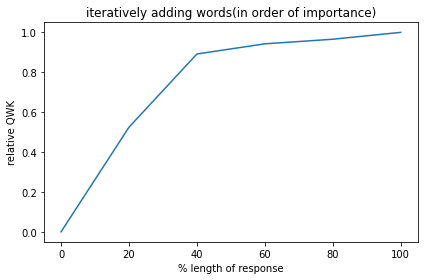

In [73]:
d
plot_and_save(d,ATTRS_DIR+'adding_top', x = '% length of response', y ='relative QWK', title= 'iteratively adding words(in order of importance)')

In [77]:
def bottom_k_attrs(tokens, attrs,k=None):
    k = min(k, len(tokens))
    return ([tokens[i] for i in np.argpartition(attrs, k)[:k]])

d2_keys = []
d2_vals = []
p_list = {}
for K in range(0,6):
  percent = K*0.2
  preds_new = []
  new_essay_list = []
  for id, essay in enumerate(essay_list):
    top_k = int(percent* len(attrs_list[id]))
    attrs = attrs_list[id]
    question_tokens = essay_list[id]
    attrs = [abs(x) for x in attrs]
    try:
      c_list = bottom_k_attrs(question_tokens[-len(attrs):] , attrs, k = top_k)
      # print(top_k, c_list)
    except Exception as e:
      c_list = list(set(question_tokens))
    if top_k==0:
      c_list = []
    
    count = 0
    new_essay = []
    for i in range(len(question_tokens[-len(attrs):])):  
      if question_tokens[-len(attrs):][i] in c_list and count<top_k:
        count +=1
        pass
      else:
        new_essay.append( question_tokens[-len(attrs):][i])
        
    # print(len(new_essay)/ len(question_tokens[-len(attrs):]))
    new_essay_padded = pad_sequences([new_essay], maxlen=MAX_SEQUENCE_LENGTH)[0]
    pred = adv.predict_and_norm(np.array([new_essay_padded]))[0]
    if round(abs(pred - pred_array_orig[id])) == 1:
      print('in')
      if id not in p_list.keys():
        p_list[id] = percent*100
      else:
        pass
    new_essay_list.append(new_essay_padded)

  # pred = adv.predict_and_norm(np.array(new_essay_list))
  # preds_new.extend(pred)
  
  # acc = cohen_kappa_score(preds_new, pred_array_orig, weights='quadratic')
  # # print(acc)
  # get_pred_stats(pred_array_orig, preds_new, ATTRS_DIR+'stats_bottom.txt', int(100-percent*100))
  # d2_keys.append(100-percent*100)
  # d2_vals.append(acc)
  # break

in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in
in


In [78]:
l = p_list.values()
sum(l)/len(l)

20.64516129032258

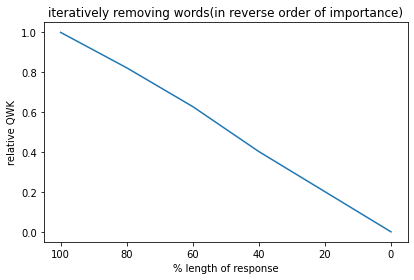

In [71]:
plot_and_save_both(d2_keys, d2_vals, ATTRS_DIR+'removing_bottom', x = '% length of response', y ='relative QWK', title= 'iteratively removing words(in reverse order of importance)')


In [ ]:
def  hlstr(string, color='white'):
    """
    Return HTML markup highlighting text with the desired color.
    """
    return "<mark style=background-color:{}>{} </mark>".format(color, string)

def colorize(attrs, cmap='PiYG'):
    """
    Compute hex colors based on the attributions for a single instance.
    Uses a diverging colorscale by default and normalizes and scales
    the colormap so that colors are consistent with the attributions.
    """
    import matplotlib as mpl
    cmap_bound = np.abs(attrs).max()
    norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.cm.get_cmap(cmap)

    # now compute hex values of colors
    colors = list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))
    return colors

def get_attributions(v = x_val[0:1]):

  explanation = ig.explain(v, 
                         baselines=None)
  
  attrs = explanation.attributions
  attrs = attrs.sum(axis=2)
  
  return attrs

def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    count = 0
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    for x in words:
      if x == None:
        count+=1
    return(words, count)

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))    

In [ ]:
# ATTRS_TSV = './drive/My Drive/IG RESULTS/P4/SKIPFLOW/attrs_4.tsv'
# batch = 1
# with open(ATTRS_TSV, 'a') as outf:
#   c=0
#   while c<len(x_val):
#     ans = ''
#     for i,v in enumerate(x_val[c:c+batch]):
#         tsv_string = ''
#         attrs = get_attributions(np.array([v]))[0]
#         words,count = sequence_to_text(v)
#         assert len(words[count:]) == len(attrs[count:])
#         question_attrs = []
#         for ind in range(len(words[count:])):
#                 question_attrs.append(
#                     '|'.join([ words[count:][ind], str(attrs[count:][ind]) ])
#                     )
#         tsv_string = ['||'.join(question_attrs)]
#         ans += '\t'.join(tsv_string) + '\n'
#         del attrs, words, question_attrs, tsv_string
#         gc.collect()
#     c+=batch
#     outf.write(ans)
#     outf.flush()
#     del ans
#     gc.collect()
#   outf.write('done')
#   outf.flush()
# print('DONE')

In [ ]:
from collections import Counter

In [ ]:
counts_list = []
top_k = 1
with open(ATTRS_TSV) as f:
    for line in f:
        line = line.strip()
        question_attrs = line.split('\t')[0]
        question_tokens = []
        attrs = []
        for word_attr in question_attrs.split('||'): 
            word, attr = word_attr.split('|')
            question_tokens.append(word)
            attrs.append(float(attr))
        k = min(top_k, len(question_tokens))
        # get top k words by attribution 
        counts_list.extend([question_tokens[i].strip() for i in np.argpartition(attrs, -k)[-k:]])
counts_list = [w for w, _ in Counter(counts_list).most_common(len(counts_list))]

In [ ]:
len(Counter(counts_list).keys())

136

In [ ]:
curve_data = {}
question_lengths = {}
all_accs = []
for K in np.append(0, np.unique(np.floor(np.geomspace(1, len(Counter(counts_list)), 25)))):
    # take K most top attributed words
    if K in curve_data:
        continue
    #whitelist = set([vocab_json['question'][w] for w, c in Counter(counts_list).most_common(int(K))])
    whitelist = set([vocab_json['question'][w] for w in counts_list[:int(K)]]) if K > 0 else set()
    print(len(whitelist))
    accs = []
    num_batches = 0
    avg_question_length_orig = 0
    avg_question_length_new = 0
    num_questions = 0
    # iterator over the validation dataset
    tq = tqdm(LOADER, desc='{} E{:03d}'.format(PREFIX, 0), ncols=0)
    for v, q, a, idx, q_len in tq:

        old_q = np.asarray(q).copy()
        old_q_len = np.asarray(q_len).copy()

        new_q = np.zeros([config.batch_size, 23])
        curr_batch_size = int(q.shape[0])
        for batch_i in range(curr_batch_size):
            len_counter = 0
            avg_question_length_orig += int(q_len[batch_i])
            for word_i, w in enumerate(q[batch_i,:int(q_len[batch_i])]):
                if int(w) in whitelist:
                    new_q[batch_i, len_counter] = int(w)
                    len_counter += 1
            if len_counter == 0:
                len_counter = 1
            avg_question_length_new += int(len_counter)
            num_questions += 1
            q_len[batch_i] = len_counter
        q_len, sorted_idxs = torch.sort(q_len, descending=True)
        new_q = new_q[sorted_idxs, :]
        idx = idx[sorted_idxs]
        v = v[sorted_idxs,:,:,:]
        a = a[sorted_idxs, :]
        old_q = old_q[sorted_idxs, :]
        old_q_len = old_q_len[sorted_idxs]
        q = torch.LongTensor(new_q)

        v = Variable(v.cuda(async=True), **var_params)
        q = Variable(q.cuda(async=True), **var_params)
        a = Variable(a.cuda(async=True), **var_params)
        q_len = Variable(q_len.cuda(async=True), **var_params)

        q_emb = embedding(q)

        out = net(v, q_emb, q_len)

        acc = utils.batch_accuracy(out.data, a.data).cpu()

        accs.append(np.array(acc.view(-1)))
        del v, q, a, idx, q_len, q_emb, acc, out, old_q, sorted_idxs, old_q_len, new_q

        if num_batches >= MAX_NUM_BATCHES:
            break
        num_batches += 1

    accs = list(np.concatenate(accs, axis=0))
    print("avg question length orig: ", float(avg_question_length_orig)/num_questions)
    print("avg question length new: ", float(avg_question_length_new)/num_questions)
    print("accuracy for ", K, " is", np.mean(accs))
    curve_data[K] = np.mean(accs)
    question_lengths[K] = float(avg_question_length_new)/num_questions

In [ ]:
print(len(Counter(counts_list)))
plt.plot(curve_data.keys(), np.divide(list(curve_data.values()), np.mean(orig_accs)))
plt.xscale('symlog')
plt.xlabel('num. words in vocab')
plt.ylabel('relative accuracy')
plt.savefig(OVERSTABILITY_CURVE_FILE, format='eps')
plt.savefig(OVERSTABILITY_CURVE_FILE.replace('eps','png'), format='png')
plt.show()
print(OVERSTABILITY_CURVE_FILE)

In [ ]:
# # v = data[0]
# v = x_val[3]
# attrs = get_attributions(np.array([v]))
# words,count = sequence_to_text(v)

# colors = colorize(attrs[count:])
# HTML("".join(list(map(hlstr, words[count:], colors))))

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


In [ ]:
# v = data[0]
v = x_val[3]
attrs = get_attributions(np.array([v]))
words,count = sequence_to_text(v)

colors = colorize(attrs[count:])
HTML("".join(list(map(hlstr, words[count:], colors))))

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


In [ ]:
def remove_token(v, token='i'):
  if token == '':
    t_id = None
  else:
    t_id = tokenizer.word_index[token]
  w = [x for x in v if x!=t_id and x!=None]
  return w

new_val = []
for i,v in enumerate(x_val):
  new_val.append(remove_token(v, 'you'))
data = pad_sequences(new_val, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
y_pred=sf.predict(np.array(data))

y_val_fin = [int(round(a*(range_max-range_min)+range_min)) for a in y_val]
# print(y_val_fin)

y_pred_fin =[int(round(a*(range_max-range_min)+range_min)) for a in y_pred.flatten().tolist()]
# print(y_pred_fin)

print(cohen_kappa_score(y_val_fin,y_pred_fin,weights="quadratic"))

0.7962656220403261


In [ ]:
def pred_val(data):
  y_pred=sf.predict([data])
  y_pred_fin =[int(round(a*(range_max-range_min)+range_min)) for a in y_pred.flatten().tolist()]
  print(y_pred_fin)

In [ ]:
y_pred=sf.predict([x_val])

y_val_fin = [int(round(a*(range_max-range_min)+range_min)) for a in y_val]
# print(y_val_fin)

y_pred_fin =[int(round(a*(range_max-range_min)+range_min)) for a in y_pred.flatten().tolist()]
# print(y_pred_fin)

print(cohen_kappa_score(y_val_fin,y_pred_fin,weights="quadratic"))

0.8004643518223017


In [ ]:
! pip install googledrivedownloader

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1CIEpiDmzLmJ6LMCVSOmCKw_eOg4ocuS4', dest_path='/content/AES.zip', unzip=True)

Unzipping...Done.


In [ ]:
print(len(y_val_fin))
print(len(y_pred_fin))

356
356
